In [3]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to C:\Users\Luz
[nltk_data]     Eva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Luz
[nltk_data]     Eva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Luz
[nltk_data]     Eva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Luz
[nltk_data]     Eva\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:

nlp = spacy.load("en_core_web_sm")

In [5]:

df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

In [6]:
df.sentimiento.unique()

array(['FAKE', 'REAL'], dtype=object)

In [7]:
df = df.set_index('Unnamed: 0')

In [8]:
df.shape

(6335, 3)

In [9]:
df.head()

,title,texto,sentimiento
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [10]:
conteo_sentimientos = df['sentimiento'].value_counts()
print(conteo_sentimientos)

sentimiento
REAL    3171
FAKE    3164
Name: count, dtype: int64


In [11]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?

In [12]:
muestras = 500  # Ajuste las muestras a 1000, 500 real y 500 fake como se ha sugerido en clase

df_real = df[df["sentimiento"] == "REAL"].sample(muestras, random_state=42)
df_fake = df[df["sentimiento"] == "FAKE"].sample(muestras, random_state=42)
df_muestras = pd.concat([df_real, df_fake]).sample(frac=1, random_state=42)  

print(f"Nuevo tamaño del dataset: {df_muestras.shape}")

Nuevo tamaño del dataset: (1000, 3)


In [13]:
conteo_sentimientos = df_muestras['sentimiento'].value_counts()
print("\nDistribución de clases en el dataset reducido:")
print(conteo_sentimientos)  #Vemos que efectivamente están balanceadas la cantidad de noticias real y fake


Distribución de clases en el dataset reducido:
sentimiento
FAKE    500
REAL    500
Name: count, dtype: int64


In [14]:
df_muestras["sentimiento"] = df_muestras["sentimiento"].map({"FAKE": 0, "REAL": 1}) #Se mapean las variables para poder trabajar mejor con los algoritmos
print(df_muestras["sentimiento"].value_counts())
print(df_muestras.head())


sentimiento
0    500
1    500
Name: count, dtype: int64
                                                        title  \
Unnamed: 0                                                      
6599        Genius Kid Trolled White House Halloween Party...   
7034             Boycott targets Trump family on retail front   
6455                            Physical Gold Demand and Fear   
7464        Comment on Macy’s “dump Trump” backfires as 30...   
4144        To grow the economy, grow small businesses: Bl...   

                                                        texto  sentimiento  
Unnamed: 0                                                                  
6599        Genius Kid Trolled White House Halloween Party...            0  
7034        Boycott targets Trump family on retail front P...            0  
6455        Physical Gold Demand and Fear Posted on Home »...            0  
7464        Posted on July 15, 2015 by Dr. Eowyn | 33 Comm...            0  
4144        Meeting small 

In [15]:
def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)

In [16]:
df_muestras["texto"] = df_muestras["texto"].apply(preprocesar_texto)
print(df_muestras.head())

                                                        title  \
Unnamed: 0                                                      
6599        Genius Kid Trolled White House Halloween Party...   
7034             Boycott targets Trump family on retail front   
6455                            Physical Gold Demand and Fear   
7464        Comment on Macy’s “dump Trump” backfires as 30...   
4144        To grow the economy, grow small businesses: Bl...   

                                                        texto  sentimiento  
Unnamed: 0                                                                  
6599        genius kid troll white house halloween party i...            0  
7034        boycott target trump family retail front parti...            0  
6455        physical gold demand fear post home silver sil...            0  
7464        post july dr eowyn comment topsy turvy world l...            0  
4144        meet small business capital technology labor n...            1  


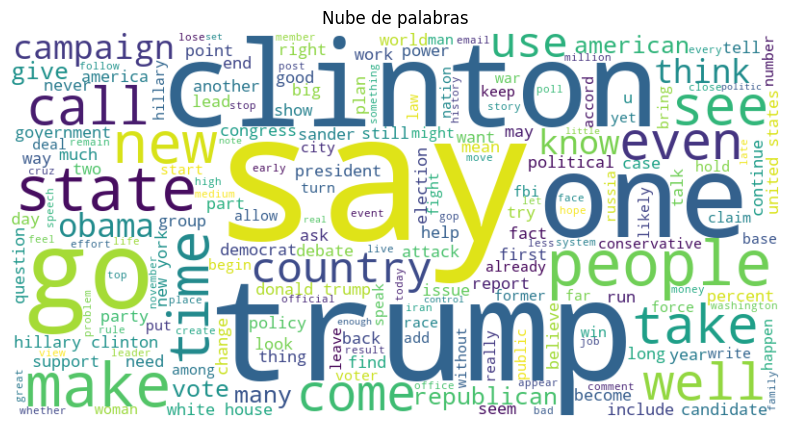

In [20]:
text_combined = " ".join(df_muestras["texto"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

In [21]:
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

In [24]:
unigramas = get_top_ngrams(df_muestras['texto'], 1)
bigramas = get_top_ngrams(df_muestras['texto'], 2)
trigramas = get_top_ngrams(df_muestras['texto'], 3)
cuatrigramas = get_top_ngrams(df_muestras['texto'], 4)

Unigramas más comunes:
    N-gram  Frecuencia
0      say        4913
1    trump        3750
2  clinton        3024
3    state        2216
4    would        2198
5      one        1906
6   people        1795
7     year        1636
8     make        1608
9      new        1590


C:\Users\Luz Eva\AppData\Local\Temp\ipykernel_16356\422321085.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


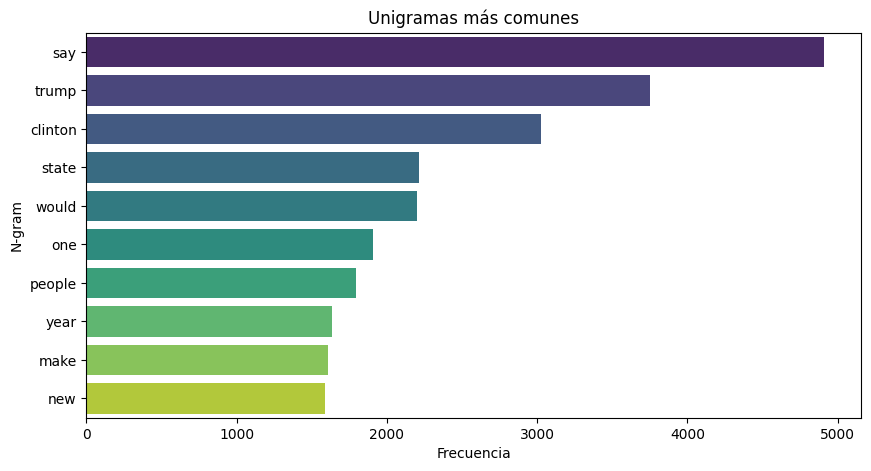

C:\Users\Luz Eva\AppData\Local\Temp\ipykernel_16356\422321085.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')



Bigramas más comunes:
             N-gram  Frecuencia
0   hillary clinton         693
1      donald trump         617
2     united states         468
3       white house         442
4          new york         416
5         trump say         227
6   secretary state         216
7   president obama         215
8     supreme court         191
9  state department         190


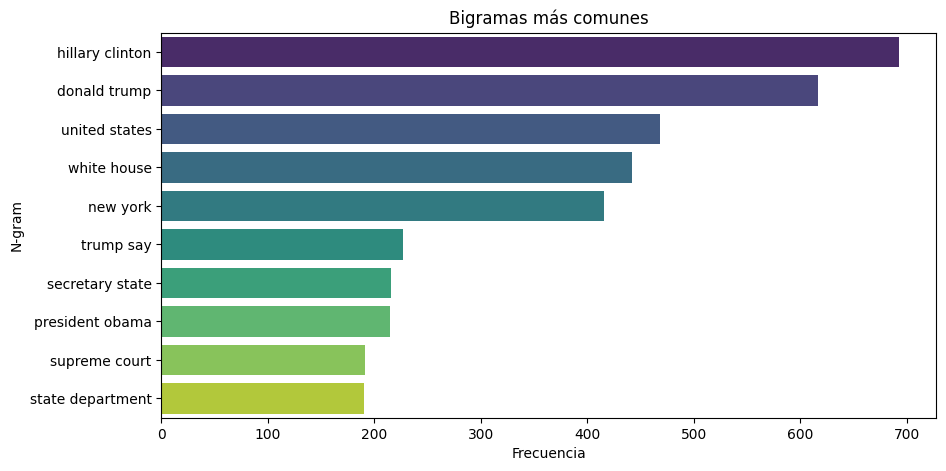


Trigramas más comunes:
                              N-gram  Frecuencia
0                     new york times         133
1             president barack obama          70
2                     case case case          64
3                       sen ted cruz          45
4            president united states          44
5             former secretary state          43
6               director james comey          42
7  republican presidential candidate          40
8                 fbi director james          39
9                wall street journal          39


C:\Users\Luz Eva\AppData\Local\Temp\ipykernel_16356\422321085.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


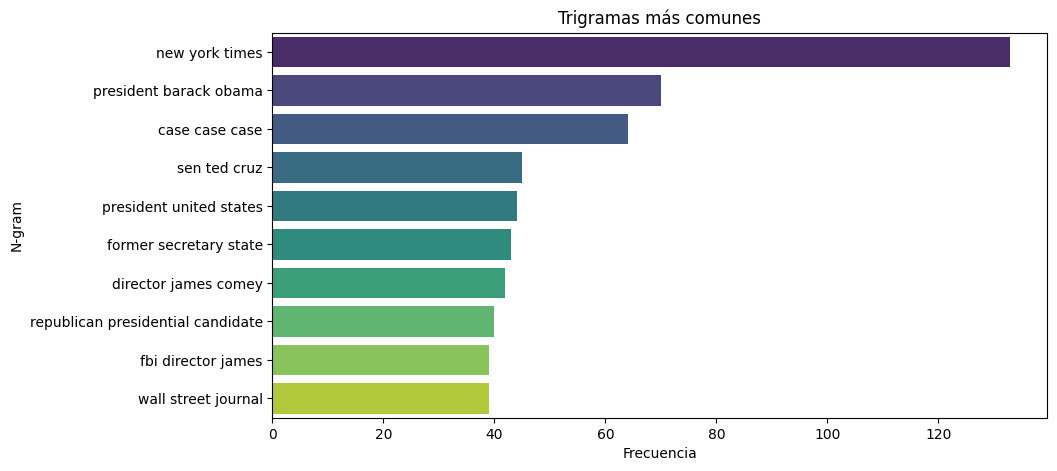


Cuatrigramas más comunes:
                            N-gram  Frecuencia
0              case case case case          63
1         fbi director james comey          39
2  majority leader mitch mcconnell          24
3             ohio gov john kasich          24
4       secretary state john kerry          23
5          house speaker paul ryan          22
6     senate majority leader mitch          21
7   attorney general loretta lynch          20
8           one every housing unit          19
9  secretary state hillary clinton          18


C:\Users\Luz Eva\AppData\Local\Temp\ipykernel_16356\422321085.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


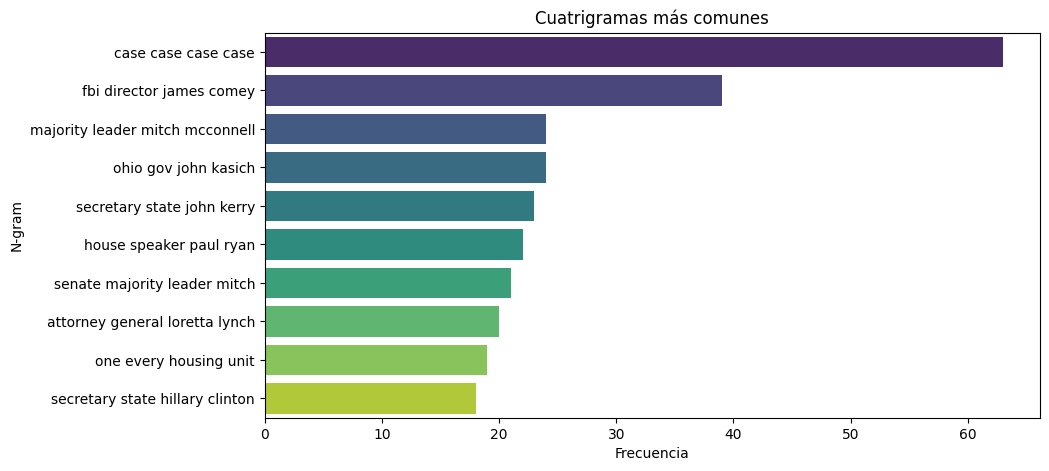

In [26]:
# Imprimir y graficar unigramas
print("Unigramas más comunes:")
print(unigramas)
plot_ngrams(unigramas, "Unigramas más comunes")

# Imprimir y graficar bigramas
print("\nBigramas más comunes:")
print(bigramas)
plot_ngrams(bigramas, "Bigramas más comunes")

# Imprimir y graficar trigramas
print("\nTrigramas más comunes:")
print(trigramas)
plot_ngrams(trigramas, "Trigramas más comunes")

# Imprimir y graficar cuatrigramas
print("\nCuatrigramas más comunes:")
print(cuatrigramas)
plot_ngrams(cuatrigramas, "Cuatrigramas más comunes")


In [27]:
X = df_muestras['texto']
y = df_muestras['sentimiento']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

Tamaño del conjunto de entrenamiento: 800
Tamaño del conjunto de prueba: 200


In [31]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.755
              precision    recall  f1-score   support

           0       0.98      0.52      0.68       100
           1       0.67      0.99      0.80       100

    accuracy                           0.76       200
   macro avg       0.83      0.76      0.74       200
weighted avg       0.83      0.76      0.74       200



In [33]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [34]:
print(f"Tamaño de tfidf_train: {tfidf_train.shape}")
print(f"Tamaño de tfidf_test: {tfidf_test.shape}")


Tamaño de tfidf_train: (800, 19636)
Tamaño de tfidf_test: (200, 19636)


In [36]:
from sklearn.linear_model import PassiveAggressiveClassifier
PassiveAggressiveClassifier?

Init signature:
PassiveAggressiveClassifier(
    *,
    C=1.0,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    shuffle=True,
    verbose=0,
    loss='hinge',
    n_jobs=None,
    random_state=None,
    warm_start=False,
    class_weight=None,
    average=False,
)
Docstring:     
Passive Aggressive Classifier.

Read more in the :ref:`User Guide <passive_aggressive>`.

Parameters
----------
C : float, default=1.0
    Maximum step size (regularization). Defaults to 1.0.

fit_intercept : bool, default=True
    Whether the intercept should be estimated or not. If False, the
    data is assumed to be already centered.

max_iter : int, default=1000
    The maximum number of passes over the training data (aka epochs).
    It only impacts the behavior in the ``fit`` method, and not the
    :meth:`~sklearn.linear_model.PassiveAggressiveClassifier.partial_fit` method.

    .. versionadded:: 0.19

tol : fl

In [37]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [38]:
y_pred2=pac.predict(tfidf_test)

In [39]:
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       100
           1       0.90      0.86      0.88       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



In [ ]:
#Según las conclusiones, el método PassiveAgressive logra dar mayour accuracy a las predicciones que se pueden lograr con el modelo creado